# 05 — Opportunity Scoring & Ranking

**Objective:** Combine all signals into a single ranked opportunity table.

## Scoring Formula
```
opportunity = 0.25 * nutritional_gap
            + 0.15 * brand_fragmentation  (1 - HHI)
            + 0.15 * category_size         (log products)
            + 0.15 * reformulation_feasibility
            + 0.15 * PL_opportunity        (1 - PL saturation)
            + 0.15 * price_gap_margin
```

## Sensitivity Analysis
1000 random Dirichlet weight combinations to test whether the top-5 ranking is robust to weight assumptions.

In [1]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print('Working directory:', os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.analysis.opportunity_scorer import (
    compute_opportunity_score,
    sensitivity_analysis,
    normalise_column,
    OpportunityWeights,
)
from src.analysis.reformulation import analyse_reformulation

sns.set_theme(style='whitegrid', palette='colorblind')
os.makedirs('results', exist_ok=True)
print('Imports OK')

Working directory: /Users/joshua/PycharmProjects/PortfolioProjectIdeas/PrivateLabelOpportunities


Imports OK


In [2]:
# Load category summary from notebook 03
cat = pd.read_parquet('data/processed/category_summary.parquet')
print(f'Categories: {len(cat)}')
print(f'Columns: {cat.columns.tolist()}')
cat.head()

Categories: 45
Columns: ['category_l1', 'pct_grade_cde', 'pl_penetration_ab', 'nutritional_gap', 'hhi', 'pl_penetration', 'total_products', 'n_products']


,category_l1,pct_grade_cde,pl_penetration_ab,nutritional_gap,hhi,pl_penetration,total_products,n_products
0,Taralli,1.000000,0.000000,1.000000,0.422017,0.000000,101,101
1,Breakfast,0.984493,0.050420,0.934855,0.002800,0.099948,7674,7674
2,Fish And Meat And Eggs,0.967900,0.043478,0.925817,0.033066,0.066643,2866,2866
3,Festive Foods,0.959627,0.076923,0.885810,0.012172,0.102484,322,322
4,Snacks,0.963461,0.087305,0.879346,0.002033,0.123048,119433,119433


## 1. Build Normalised Components

Each component normalised to [0, 1] where 1 = best opportunity.

In [3]:
# 1. Nutritional gap (already computed, higher = better opportunity)
cat['nutritional_gap_norm'] = normalise_column(cat['nutritional_gap'])

# 2. Brand fragmentation (1 - HHI, higher = more fragmented = easier entry)
cat['brand_fragmentation_norm'] = normalise_column(1 - cat['hhi'])

# 3. Category size (log-scaled product count, higher = bigger market)
cat['category_size_norm'] = normalise_column(np.log1p(cat['n_products']))

# 4. PL opportunity (1 - PL penetration, higher = less PL competition)
cat['pl_opportunity_norm'] = normalise_column(1 - cat['pl_penetration'])

# 5. Reformulation feasibility — derive from OFF data
#    We'll compute what fraction of products in each category COULD reach B grade
#    with single-nutrient changes. Categories where reformulation is easier score higher.
df_off = pd.read_parquet('data/processed/off_eu_clean.parquet')
has_score = df_off['nutriscore_grade'].isin(['a', 'b', 'c', 'd', 'e'])
has_cat = df_off['category_l1'].notna() & (df_off['category_l1'] != 'Unknown')
df_scored = df_off[has_score & has_cat].copy()

reform_results = analyse_reformulation(df_scored, category_col='category_l1', target_grade='b')

# Score: average reduction needed (lower = easier = higher score)
reform_scores = {}
for category, targets in reform_results.items():
    if targets:
        # Use minimum reduction % needed across nutrients (easiest path)
        min_reduction = min(t.reduction_pct for t in targets)
        reform_scores[category] = min_reduction

cat['min_reduction_pct'] = cat['category_l1'].map(reform_scores)
# Categories with no path get max reduction (worst), those already at B get 0 (best)
cat['min_reduction_pct'] = cat['min_reduction_pct'].fillna(100.0)
# Invert: lower reduction = higher feasibility
cat['reformulation_feasibility_norm'] = normalise_column(100 - cat['min_reduction_pct'])

# 6. Price gap margin — we don't have per-category price gaps from OFF,
#    so we'll use a uniform placeholder (0.5) for now.
#    This gets refined when supermarket data is category-matched.
cat['price_gap_margin_norm'] = 0.5

# Show the normalised components
norm_cols = ['nutritional_gap_norm', 'brand_fragmentation_norm', 'category_size_norm',
             'reformulation_feasibility_norm', 'pl_opportunity_norm', 'price_gap_margin_norm']
display(cat[['category_l1'] + norm_cols].round(3).head(10))
print(f'\nReformulation paths found for {len(reform_scores)} categories')

,category_l1,nutritional_gap_norm,brand_fragmentation_norm,category_size_norm,reformulation_feasibility_norm,pl_opportunity_norm,price_gap_margin_norm
0,Taralli,1.000,0.379,0.000,0.746,1.000,0.5
1,Breakfast,0.933,0.998,0.557,0.207,0.602,0.5
2,Fish And Meat And Eggs,0.923,0.954,0.430,0.055,0.735,0.5
3,Festive Foods,0.882,0.985,0.148,0.000,0.592,0.5
4,Snacks,0.875,1.000,0.910,0.000,0.510,0.5
5,Meat Products,0.851,0.906,0.058,0.258,1.000,0.5
6,Crepes And Galettes,0.838,0.989,0.325,0.914,0.469,0.5
7,Desserts,0.833,0.992,0.644,0.000,0.342,0.5
8,Fats & Oils,0.829,0.998,0.271,0.045,0.762,0.5
9,Spreads,0.804,0.998,0.387,0.531,0.612,0.5



Reformulation paths found for 77 categories


## 2. Compute Composite Opportunity Score

In [4]:
# Default weights: nutritional gap weighted highest (25%), rest equal (15% each)
scored = compute_opportunity_score(cat, OpportunityWeights())

# Display top 15
display_cols = ['category_l1', 'opportunity_score', 'nutritional_gap', 'hhi',
                'pl_penetration', 'n_products', 'min_reduction_pct']
print('Top 15 Opportunity Categories (default weights):\n')
display(scored[display_cols].head(15).round(3))

# Save scored results
scored.to_parquet('data/processed/opportunity_scores.parquet', index=False)
print(f'\nSaved {len(scored)} category scores to data/processed/opportunity_scores.parquet')

Top 15 Opportunity Categories (default weights):



,category_l1,opportunity_score,nutritional_gap,hhi,pl_penetration,n_products,min_reduction_pct
6,Crepes And Galettes,0.689,0.843,0.009,0.133,1269,27.4
13,Condiments & Sauces,0.672,0.767,0.003,0.123,30565,62.5
1,Breakfast,0.663,0.935,0.003,0.100,7674,83.6
4,Snacks,0.657,0.879,0.002,0.123,119433,100.0
9,Spreads,0.655,0.810,0.003,0.097,2063,57.8
0,Taralli,0.644,1.000,0.422,0.000,101,40.8
2,Fish And Meat And Eggs,0.632,0.926,0.033,0.067,2866,95.6
36,Seafood,0.626,0.446,0.005,0.190,28310,20.6
5,Meat Products,0.621,0.855,0.065,0.000,159,79.5
11,Broths,0.616,0.787,0.026,0.155,238,32.5



Saved 45 category scores to data/processed/opportunity_scores.parquet


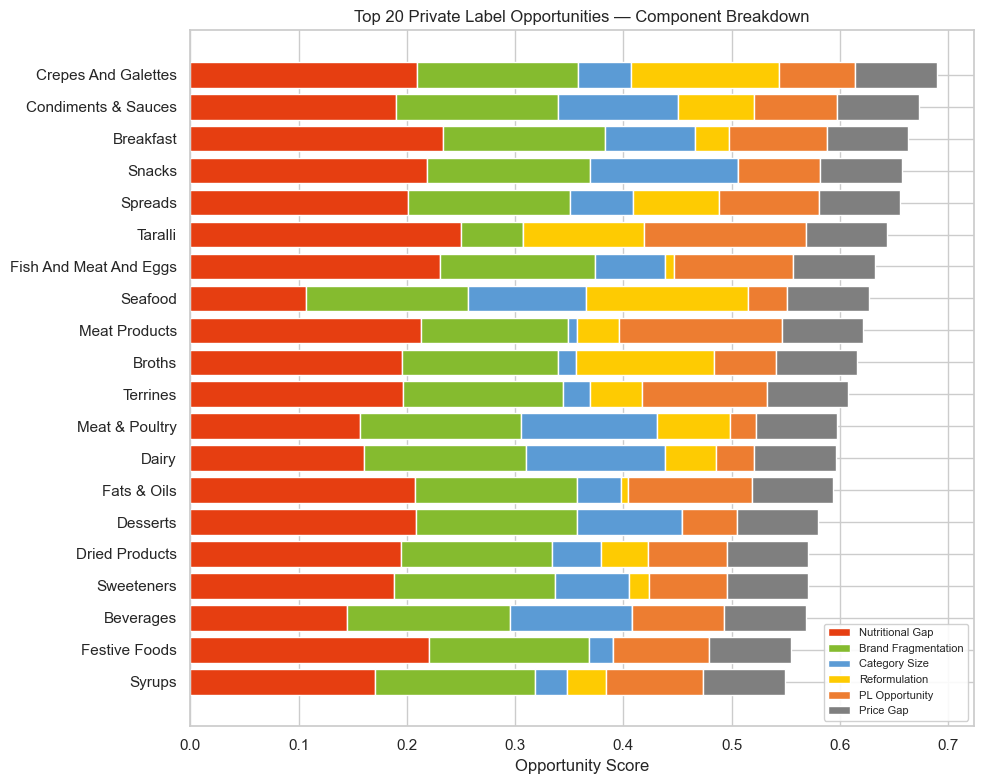

Saved: results/opportunity_scores_breakdown.png


In [5]:
# Visualise: horizontal bar chart of top 20 scores with component breakdown
top20 = scored.head(20).copy().sort_values('opportunity_score')

fig, ax = plt.subplots(figsize=(10, 8))
weights = OpportunityWeights()
component_colours = {
    'Nutritional Gap': '#e63e11',
    'Brand Fragmentation': '#85bb2f',
    'Category Size': '#5b9bd5',
    'Reformulation': '#fecb02',
    'PL Opportunity': '#ed7d31',
    'Price Gap': '#7f7f7f',
}

left = np.zeros(len(top20))
components = [
    ('Nutritional Gap', 'nutritional_gap_norm', weights.nutritional_gap),
    ('Brand Fragmentation', 'brand_fragmentation_norm', weights.brand_fragmentation),
    ('Category Size', 'category_size_norm', weights.category_size),
    ('Reformulation', 'reformulation_feasibility_norm', weights.reformulation_feasibility),
    ('PL Opportunity', 'pl_opportunity_norm', weights.pl_opportunity),
    ('Price Gap', 'price_gap_margin_norm', weights.price_gap_margin),
]

for label, col, weight in components:
    vals = (top20[col] * weight).values
    ax.barh(top20['category_l1'], vals, left=left,
            color=component_colours[label], label=label)
    left += vals

ax.set_xlabel('Opportunity Score')
ax.set_title('Top 20 Private Label Opportunities — Component Breakdown')
ax.legend(loc='lower right', fontsize=8, framealpha=0.9)
plt.tight_layout()
plt.savefig('results/opportunity_scores_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/opportunity_scores_breakdown.png')

## 3. Sensitivity Analysis

How robust is the ranking to weight assumptions? We run 1000 simulations with random Dirichlet-distributed weights (all 6 weights sum to 1, but their relative sizes vary randomly).

If a category's mean rank is consistently low (near 1) with low standard deviation, it's a robust recommendation regardless of how we weight the factors.

In [6]:
# Run Monte Carlo sensitivity analysis
rank_stats = sensitivity_analysis(scored, n_simulations=1000, seed=42)

print('Ranking Stability (1000 random weight combinations):\n')
display(rank_stats.head(15).round(2))

Ranking Stability (1000 random weight combinations):



,mean_rank,std_rank,min_rank,max_rank
category_l1,,,,
Condiments & Sauces,5.83,3.87,1,21
Crepes And Galettes,6.91,6.21,1,27
Spreads,7.53,3.13,1,17
Breakfast,7.59,3.88,1,19
Snacks,9.01,7.65,1,31
Fish And Meat And Eggs,11.32,5.92,2,29
Seafood,11.46,11.13,1,39
Terrines,13.30,6.51,2,31
Meat Products,13.70,10.50,1,40


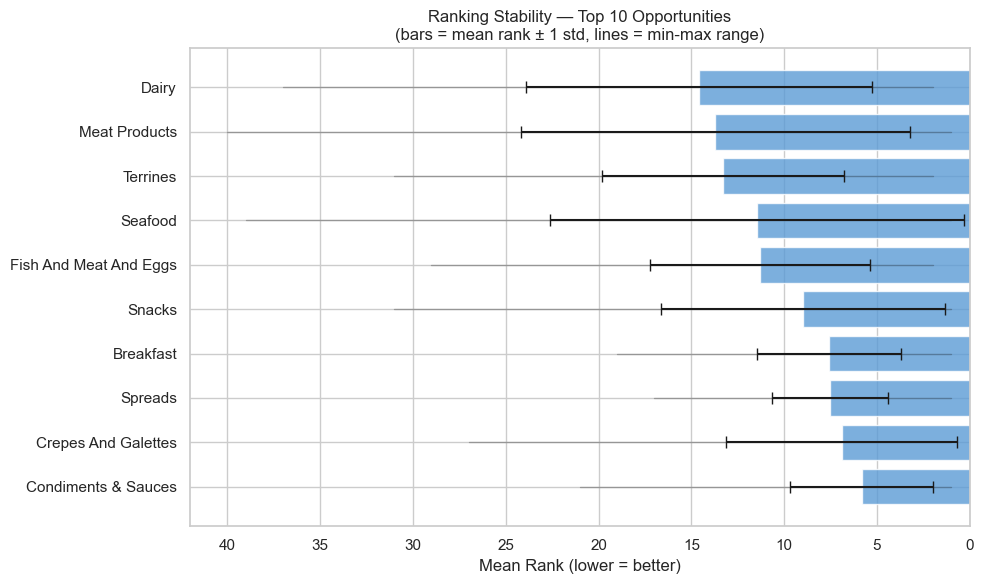

Saved: results/ranking_sensitivity.png


In [7]:
# Visualise rank distributions for top 10
top10_cats = rank_stats.head(10).index.tolist()

fig, ax = plt.subplots(figsize=(10, 6))
top10_stats = rank_stats.loc[top10_cats].sort_values('mean_rank')

y = np.arange(len(top10_stats))
ax.barh(y, top10_stats['mean_rank'], xerr=top10_stats['std_rank'],
        color='#5b9bd5', capsize=4, alpha=0.8)

# Show min-max range as thin lines
for i, (cat_name, row) in enumerate(top10_stats.iterrows()):
    ax.plot([row['min_rank'], row['max_rank']], [i, i], 'k-', alpha=0.3, linewidth=1)

ax.set_yticks(y)
ax.set_yticklabels(top10_stats.index)
ax.set_xlabel('Mean Rank (lower = better)')
ax.set_title('Ranking Stability — Top 10 Opportunities\n(bars = mean rank ± 1 std, lines = min-max range)')
ax.invert_xaxis()
plt.tight_layout()
plt.savefig('results/ranking_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/ranking_sensitivity.png')

## 4. Opportunity Quadrant

Plot nutritional gap vs category size (bubble size = score), highlighting the sweet spot: large categories with high nutritional gaps.

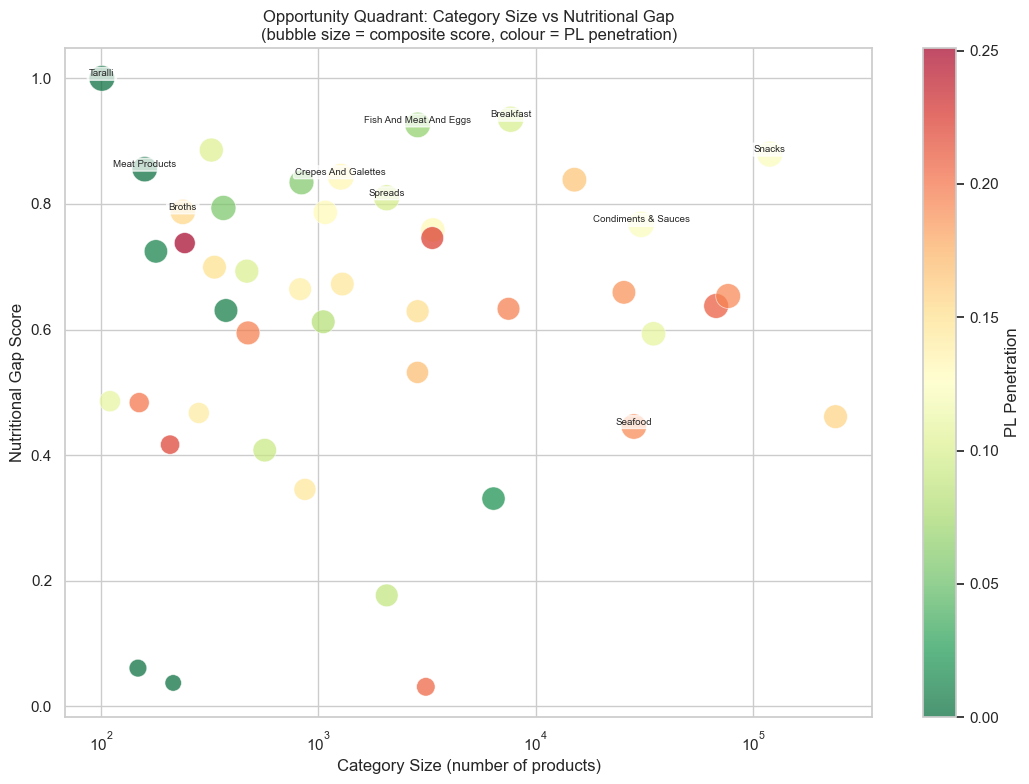

Saved: results/opportunity_quadrant.png


In [8]:
fig, ax = plt.subplots(figsize=(11, 8))

x = scored['n_products']
y = scored['nutritional_gap']
size = scored['opportunity_score'] * 500 + 20
colour = scored['pl_penetration']

scatter = ax.scatter(x, y, s=size, c=colour, cmap='RdYlGn_r', alpha=0.7, edgecolors='white', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('PL Penetration')

# Label top 10
for _, row in scored.head(10).iterrows():
    ax.annotate(row['category_l1'], (row['n_products'], row['nutritional_gap']),
                fontsize=7, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

ax.set_xlabel('Category Size (number of products)')
ax.set_ylabel('Nutritional Gap Score')
ax.set_title('Opportunity Quadrant: Category Size vs Nutritional Gap\n(bubble size = composite score, colour = PL penetration)')
ax.set_xscale('log')
plt.tight_layout()
plt.savefig('results/opportunity_quadrant.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/opportunity_quadrant.png')

## 5. Weight Sensitivity Heatmap

Show how the top-5 ranking changes when we up-weight each individual factor.

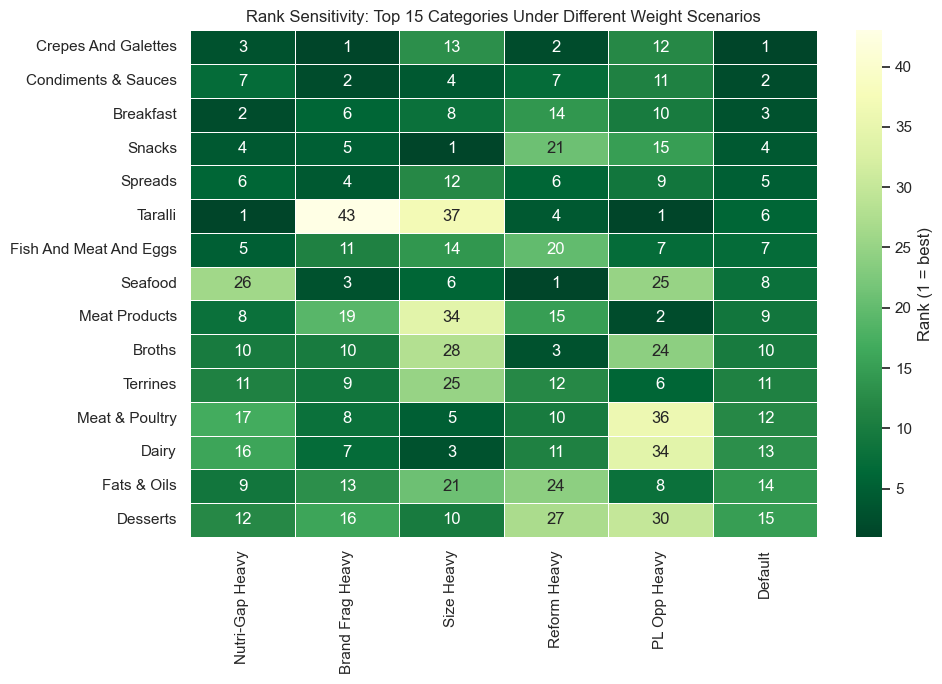

Saved: results/weight_sensitivity_heatmap.png


In [9]:
# Test 6 alternative weight scenarios (each factor gets 50% weight, rest split equally)
scenarios = {
    'Nutri-Gap Heavy': OpportunityWeights(0.50, 0.10, 0.10, 0.10, 0.10, 0.10),
    'Brand Frag Heavy': OpportunityWeights(0.10, 0.50, 0.10, 0.10, 0.10, 0.10),
    'Size Heavy': OpportunityWeights(0.10, 0.10, 0.50, 0.10, 0.10, 0.10),
    'Reform Heavy': OpportunityWeights(0.10, 0.10, 0.10, 0.50, 0.10, 0.10),
    'PL Opp Heavy': OpportunityWeights(0.10, 0.10, 0.10, 0.10, 0.50, 0.10),
    'Default': OpportunityWeights(),
}

rank_matrix = {}
for name, weights in scenarios.items():
    s = compute_opportunity_score(cat.copy(), weights)
    s['rank'] = range(1, len(s) + 1)
    rank_matrix[name] = s.set_index('category_l1')['rank']

rank_df = pd.DataFrame(rank_matrix)

# Show top 15 from default, and their ranks under other scenarios
top15_default = rank_df.nsmallest(15, 'Default').index
rank_show = rank_df.loc[top15_default].sort_values('Default')

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(rank_show, annot=True, fmt='.0f', cmap='YlGn_r', linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Rank (1 = best)'})
ax.set_title('Rank Sensitivity: Top 15 Categories Under Different Weight Scenarios')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('results/weight_sensitivity_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/weight_sensitivity_heatmap.png')

## Key Takeaways

The final ranked opportunity table and sensitivity analysis feed into Notebook 06 for executive-level findings and recommendations.